# DIY software rasterizer
## How-to https://github.com/ssloy/tinyrenderer/wiki by D. Sokolov 

### BeakerX 1.3.0 Java 11.0.1 

##  Java part - JRasterizer library
- core functionality
- more easy code with a lot of cycles
- each lesson extends previous

##  Clojure part 
- parser for resource files
- JRasterizer wrapper

In [1]:
(str *clojure-version*)

{:major 1, :minor 9, :incremental 0, :qualifier nil}

# 0 - Intro

### TODO
* create and save image
* setPixel method

In [2]:
%classpath add jar ./JRasterizer/build/libs/JRasterizer-0.1.0.jar

In [3]:
(-> "jar:file:./JRasterizer/build/libs/JRasterizer-0.1.0-sources.jar!/JRasterizer/Lesson0.java"
  java.net.URL.
  .openStream
  slurp)

package JRasterizer;

import java.awt.image.BufferedImage;
import java.util.Arrays;

public class Lesson0 {
    BufferedImage bufferedImage;
    int[] data;
    int size;

    public Lesson0(int size) {
        this.size = size;
        bufferedImage = new BufferedImage(size, size, BufferedImage.TYPE_INT_ARGB);
        data = new int[size * size];
        Arrays.fill(data, 0xff000000);
    }

    public void test()  {
        setPixel(new int[]{1, 7}, 0xffff0000);
        setPixel(new int[]{3, 9}, 0xff00ffff);
        setPixel(new int[]{1, 1}, 0xff00ffff);
        setPixel(new int[]{9, 6}, 0xff00ffff);
        setPixel(new int[]{1, 2}, 0xffff0000);
        setPixel(new int[]{7, 7}, 0xff00ff00);
    }

    public void setPixel(int[] point, int color){
        if (0 <= point[0] && point[0] < size && 0 <= point[1] && point[1] < size) {
            data[point[0] + size * (size - point[1] - 1)] = color;
        }
    }

    public void flushImage(){
        bufferedImage.setRGB(0, 0, size, 

### Commentaries
- point is int array of x,y,z coordinates (maybe more)
- z-coordinate really not used for this moment, and we can skip it
- color is int32, for 0xff223344 : ff-alpha, 22-red, 33-green, 44-blue

In [4]:
(import '[JRasterizer Lesson0])

class JRasterizer.Lesson0

In [5]:
(defn save-image [bi s]
  (javax.imageio.ImageIO/write bi "png" (java.io.File. (str s ".png"))))

#'beaker_clojure_shell_f9c4172f-eeda-4daf-8cb6-3a3696a48033/save-image

In [6]:
(save-image 
  (let [pi (Lesson0. 10)]
    (.test pi)
    (.flushImage pi)
    (.getBufferedImage pi))
  "img0")

true

<p>img0.png</p>
<img src="img0.png" style="width:100px;height:100px;">

In [7]:
%%python
from IPython.display import Image
Image("img0.png")

# 1 - Wireframe render

### TODO
* parse model from .obj file
* draw lines

In [8]:
(-> "jar:file:./JRasterizer/build/libs/JRasterizer-0.1.0-sources.jar!/JRasterizer/Lesson1.java"
  java.net.URL.
  .openStream
  slurp)

package JRasterizer;

public class Lesson1 extends Lesson0 {

    public Lesson1(int size) {
        super(size);
    }

    public void drawLine (int[] p1, int[] p2, int color) {
        if (p1[1] == p2[1]){
            for (int i=Math.min(p1[0], p2[0]); i<=Math.max(p1[0], p2[0]); i++){
                setPixel(new int[]{i, p1[1]}, color);
            }
        } else if(Math.abs(p2[0] - p1[0]) > Math.abs(p2[1] - p1[1])){
            float t = ((float) p2[1] - p1[1])/(p2[0] - p1[0]);
            int startx = Math.min(p1[0], p2[0]);
            int starty = t < 0 ? Math.max(p1[1], p2[1]) : Math.min(p1[1], p2[1]);
            for (int i=0; i<= Math.abs(p1[0] - p2[0]); i++){
                setPixel(new int[]{i + startx, (int) (i*t) + starty}, color);
            }
        } else {
            float t = ((float) p2[0] - p1[0])/(p2[1] - p1[1]);
            int starty = Math.min(p1[1], p2[1]);
            int startx = t < 0 ? Math.max(p1[0], p2[0]) : Math.min(p1[0], p2[0]);
            for

### Commentaries
- horizontal line with p1[1]=p2[1] y-coordinate is const, also checks lines with 0 length 

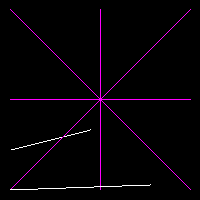

In [9]:
(import '[JRasterizer Lesson1])

(let [pi (Lesson1. 200)]
    (.test pi)
    (.drawLine pi (int-array [10 10]) (int-array [150 15]) 56)
    (.flushImage pi)
    (.getBufferedImage pi))

In [10]:
;; TEST parser
(defn handle-line [line]
    (println line))

(with-open  [rdr (clojure.java.io/reader "./resources/african_head.obj")]
  (let [lines (line-seq rdr)]
    (dorun
     (map handle-line (take 10 lines)))))

v -0.000581696 -0.734665 -0.623267
v 0.000283538 -1 0.286843
v -0.117277 -0.973564 0.306907
v -0.382144 -0.890788 0.221243
v -0.247144 -0.942602 0.276051
v -0.656078 -0.718512 -0.109025
v -0.609847 -0.786562 0.0198068
v -0.66248 -0.632053 -0.244271
v -0.511812 -0.845392 0.127809
v -0.609326 -0.569868 -0.41571


null

In [11]:
(def trans-vs (transient []))
(def trans-fs (transient []))

(defn handle-line [s]
  (let [v (clojure.string/split s #" ")]
    (cond
      (= "v" (first v)) (conj! trans-vs (map #(Double/parseDouble %) (rest v)))
      (= "f" (first v)) (conj! trans-fs (map (comp #(Integer/parseInt %) #(re-find #"^\d+" %)) (rest v)))
      :else             nil)))


(with-open  [rdr (clojure.java.io/reader "./resources/african_head.obj")]
  (let [lines (line-seq rdr)]
    (dorun
     (map handle-line lines))))

(def vs (persistent! trans-vs))  
(def fs (persistent! trans-fs))

;; Vertexes 
(def triangles 
 (mapv 
   (fn [[a b c]] [(get vs (dec a)) (get vs (dec b)) (get vs (dec c))])
   fs))

#'beaker_clojure_shell_f9c4172f-eeda-4daf-8cb6-3a3696a48033/triangles

In [12]:
(take 5 fs) ; vertex indices

[[24, 25, 26], [24, 26, 23], [28, 29, 30], [28, 30, 27], [32, 33, 34]]

In [13]:
(take 3 vs) ; vertex coordinates

[[-5.81696E-4, -0.734665, -0.623267], [2.83538E-4, -1.0, 0.286843], [-0.117277, -0.973564, 0.306907]]

In [14]:
(require '[clojure.java.shell :as shell])

(:out (shell/sh "head" "./resources/african_head.obj"))

v -0.000581696 -0.734665 -0.623267
v 0.000283538 -1 0.286843
v -0.117277 -0.973564 0.306907
v -0.382144 -0.890788 0.221243
v -0.247144 -0.942602 0.276051
v -0.656078 -0.718512 -0.109025
v -0.609847 -0.786562 0.0198068
v -0.66248 -0.632053 -0.244271
v -0.511812 -0.845392 0.127809
v -0.609326 -0.569868 -0.41571


In [15]:
(take 2 triangles)

[[[0.134781, -0.14723, 0.48805], [0.131261, -0.132153, 0.49872], [0.14749, -0.135105, 0.489565]], [[0.134781, -0.14723, 0.48805], [0.14749, -0.135105, 0.489565], [0.153371, -0.140519, 0.477416]]]

- Triangle -> 3 points
- Point -> [x,y,z] coordinates

### Some transducers:
Transducer - abstraction of transformation. It's like a transformation without an object.

In [16]:
(defn scale-points
  [xsize]
  (map (fn [point]
        (map (fn [coordinate]
               (map #(int (+ (* % 0.44 xsize) (/ xsize 2))) coordinate))
              point))))

(def scale300 (scale-points 300))

#'beaker_clojure_shell_f9c4172f-eeda-4daf-8cb6-3a3696a48033/scale300

If we apply scale300 to vector of triangles, each coordinate for each point for each triangle will be changed

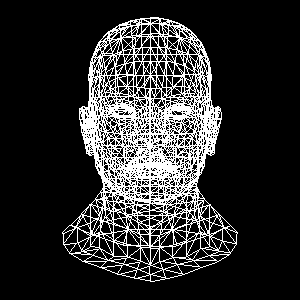

In [17]:
(let [pi (Lesson1. 300)]
  (doseq [t (->> triangles
                 (eduction scale300)
                 (map #(map int-array %)))]
    (.drawLine pi (first t)  (second t) 56) ; 56 is color 
    (.drawLine pi (second t) (last t)   56)
    (.drawLine pi (first t)  (last t)   56))
 (.flushImage pi)
 (.getBufferedImage pi))

In [18]:
(defn rotate-angle 
 [angle]
 (map 
   (fn [point] 
    (map (fn [[x y z]] 
             [(+ (* x (Math/cos (* angle 1/180 Math/PI)))
                 (* z (Math/sin (* angle 1/180 Math/PI)))) y z]) 
         point))))                                 

#'beaker_clojure_shell_f9c4172f-eeda-4daf-8cb6-3a3696a48033/rotate-angle

Now we can change and compose transducers

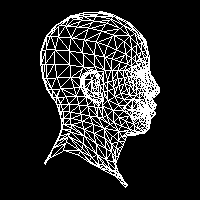

In [19]:
(let [xsize 200
      scale (scale-points xsize)
      pi    (Lesson1. xsize)]
 (doseq [t (->> triangles
                (eduction (comp (rotate-angle 90) scale))
                (map #(map int-array %)))]
      (.drawLine pi (first t)  (second t) 56)
      (.drawLine pi (second t) (last t)   56)
      (.drawLine pi (first t)  (last t)   56))
    
    (.flushImage pi)
    (.getBufferedImage pi))

In [20]:
%import com.twosigma.beakerx.widget.IntSlider

In [21]:
(def slider (new com.twosigma.beakerx.widget.IntSlider))
(.setDescription slider "AngleLR")
(.setMin slider 0)
(.setMax slider 360)
slider

In [22]:
(defn draw-head []
  (let [xsize 300
        scale (scale-points xsize)
        pi    (Lesson1. xsize)]
    (doseq [t (->> triangles
                (eduction (comp (rotate-angle (.getValue slider)) scale))
                (map #(map int-array %)))]
      (.drawLine pi (first t)  (second t) 56)
      (.drawLine pi (second t) (last t)   56)
      (.drawLine pi (first t)  (last t)   56))
    
    (.flushImage pi)
    (.getBufferedImage pi)))

#'beaker_clojure_shell_f9c4172f-eeda-4daf-8cb6-3a3696a48033/draw-head

In [23]:
slider

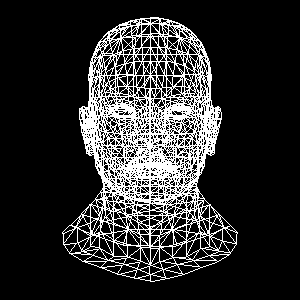

In [24]:
(draw-head)

# 2 - Filling triangles

### TODO
- work with colors
- calculate colors by function

In [25]:
;; Util function
(defn hex->int 
  "converts long ints from 0 to 0xffffffff to int32"
  [i]
  (if (>= i (bit-shift-left 1 31))
    (bit-shift-right (bit-shift-left i 32) 32)
    i))

#'beaker_clojure_shell_f9c4172f-eeda-4daf-8cb6-3a3696a48033/hex->int

In [26]:
;; Example
(hex->int 0xfffffffa)

-6

In [27]:
(-> "jar:file:./JRasterizer/build/libs/JRasterizer-0.1.0-sources.jar!/JRasterizer/Lesson2.java"
  java.net.URL.
  .openStream
  slurp)

package JRasterizer;

import java.util.Arrays;
import java.util.Comparator;

public class Lesson2 extends Lesson1 {

    int[] zbuffer = new int[size * size];

    public Lesson2(int size) {
        super(size);
    }

    public void drawTriangle(int[] p1, int[] p2, int[] p3, int color){
        int[][] points = new int[3][3];
        points[0] = p1;
        points[1] = p2;
        points[2] = p3;
        Arrays.sort(points, Comparator.comparing(it -> it[1]));


        double kb = (double) (points[2][0] - points[0][0])/(points[2][1] - points[0][1]);
        double ka = (double) (points[2][0] - points[1][0])/(points[2][1] - points[1][1]);
        double kc = (double) (points[1][0] - points[0][0])/(points[1][1] - points[0][1]);

        for (int i = 0; i < points[1][1] - points[0][1]; i++){
            drawLine(new int[]{points[0][0] + (int) (kb * i), points[0][1] + i, points[0][2]},
                    new int[]{points[0][0] + (int) (kc * i), points[0][1] + i, points[0][2]}, color);
 

### Commentaries
- now we start use 3 coordinates and expect points as arrays of size >= 3
- points with all z=0 we can draw as before
- if point have z>0 we don't see it.

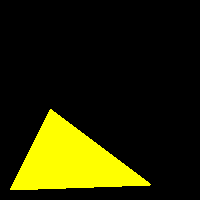

In [28]:
(import '[JRasterizer Lesson2])

(let [pi (Lesson2. 200)]
    (.drawTriangle pi (int-array [10 10 0]) (int-array [150 15 0]) (int-array [50 90 0]) (hex->int 0xffffff00))
    (.flushImage pi)
    (.getBufferedImage pi))

In [29]:
(defn draw-head []
  (let [xsize  300
        color1 (hex->int 0xffffff00)
        color2 (hex->int 0xffff0000)
        scale  (scale-points xsize)
        pi     (Lesson2. xsize)]
    (doseq [t (->> triangles
                (eduction (comp (rotate-angle (.getValue slider)) scale))
                (map #(map (fn [[x y z]] [x y 0]) %))   
                (map #(map int-array %)))]
      (.drawTriangle pi (first t)  (second t) (last t) color1)
      (.drawLine pi (first t)  (second t) color2)
      (.drawLine pi (second t) (last t)   color2)
      (.drawLine pi (first t)  (last t)   color2)
        #_(println (aget (first t) 2)))
    
    (.flushImage pi)
    (.getBufferedImage pi)))

#'beaker_clojure_shell_f9c4172f-eeda-4daf-8cb6-3a3696a48033/draw-head

In [30]:
slider

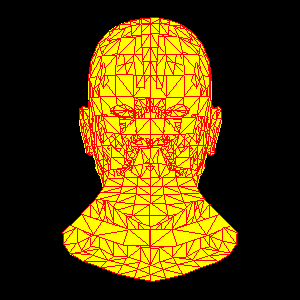

In [31]:
(draw-head) 

In [32]:
(defn rotate-angle-with-z 
 [angle]
 (map 
   (fn [point] 
    (map (fn [[x y z]] 
             [(+ (* x (Math/cos (* angle 1/180 Math/PI)))
                 (* z (Math/sin (* angle 1/180 Math/PI))))
              y
              (+ (* x (Math/sin (* angle 1/180 Math/PI)))
                 (* z (Math/cos (* angle 1/180 Math/PI))))]) 
         point))))  

#'beaker_clojure_shell_f9c4172f-eeda-4daf-8cb6-3a3696a48033/rotate-angle-with-z

In [33]:
slider

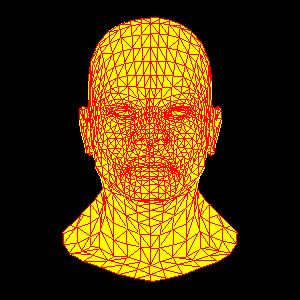

In [34]:
(let [xsize  300
      color1 (hex->int 0xffffff00)
      color2 (hex->int 0xffff0000)
      scale  (scale-points xsize)
      pi     (Lesson2. xsize)]
  (doseq [t (->> triangles
              (eduction (comp (rotate-angle-with-z (.getValue slider)) scale))
              ;; Sorting is heavy operation
              ;; We sort only by one point from triangle
              (sort-by (fn [t] (last (first t))))  
              (map #(map (fn [[x y z]] [x y 0]) %))                
              (map #(map int-array %)))]
    (.drawTriangle pi (first t)  (second t) (last t) color1)
    (.drawLine pi (first t)  (second t) color2)
    (.drawLine pi (second t) (last t)   color2)
    (.drawLine pi (first t)  (last t)   color2))

    (.flushImage pi)
    (.getBufferedImage pi))

In [35]:
slider

In [36]:
(defn normalize [[[f1 g1 h1] [f2 g2 h2] [f3 g3 h3]]]
  (let [vx1 (- f1 f2)
        vy1 (- g1 g2)
        vz1 (- h1 h2)
        vx2 (- f2 f3)
        vy2 (- g2 g3)
        vz2 (- h2 h3)]

    [(- (* vy1 vz2) (* vy2 vz1))
     (- (* vx1 vz2) (* vx2 vz1))
     (- (* vy1 vx2) (* vy2 vx1))]))

#'beaker_clojure_shell_f9c4172f-eeda-4daf-8cb6-3a3696a48033/normalize

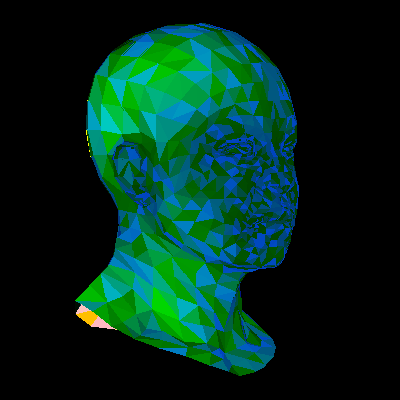

In [37]:
(let [xsize  400
      color1 (hex->int 0xffffff00)
      color2 (hex->int 0xffff0000)
      scale  (scale-points xsize)
      pi     (Lesson2. xsize)]
  (doseq [t (->> triangles
               
              (eduction  (comp (rotate-angle 50) scale))
              (map #(map (fn [[x y z]] [x y (+ (* z -1) 0)]) %))
              (map #(map int-array %)))]
    (.drawTriangle pi (first t) (second t) (last t) 
                   ;; calculate color function not ready for all angles
                   (hex->int (+ 0xff000000  (int (* 256 (+ 60 (apply + (map * (normalize t) [0 0 -0.25])))))))))

    (.flushImage pi)
    (.getBufferedImage pi))

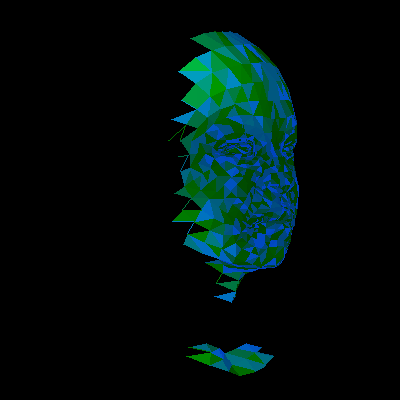

In [38]:
(let [xsize  400
      color1 (hex->int 0xffffff00)
      color2 (hex->int 0xffff0000)
      scale  (scale-points xsize)
      pi     (Lesson2. xsize)]
  (doseq [t (->> triangles
               
              (eduction  (comp (rotate-angle 50) scale))
              (map #(map (fn [[x y z]] [x y (+ (* z -1) 240)]) %)) ; zBuffer works without sorting
              (map #(map int-array %)))]
    (.drawTriangle pi (first t) (second t) (last t) 
                   ;; calculate color function not ready for all angles
                   (hex->int (+ 0xff000000  (int (* 256 (+ 60 (apply + (map * (normalize t) [0 0 -0.25])))))))))

    (.flushImage pi)
    (.getBufferedImage pi))

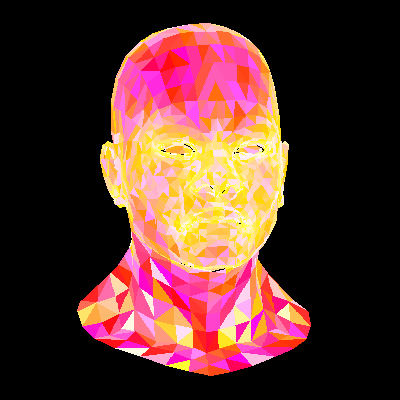

In [270]:
(let [xsize  400
      color1 (hex->int 0xffffff00)
      color2 (hex->int 0xffff0000)
      scale  (scale-points xsize)
      pi     (Lesson2. xsize)]
  (doseq [t (->> triangles
               
              (eduction  (comp (rotate-angle 10) scale))
              (map #(map (fn [[x y z]] [x y (+ (* z -1) 0)]) %))
              (map #(map int-array %)))]
    (.drawTriangle pi (first t) (second t) (last t) 
                   ;; color not right
                   (hex->int (- 0xff000000
                                (Math/abs (int (* 20  (apply + (map * (normalize t) [0 0 -11])))))))))
    (.flushImage pi)
    (.getBufferedImage pi))